In [1]:
import re


# Assignment 2: Analyzing large datasets with Spark.


For this assignment, you will need to make sure you're running from a PySpark docker environment I introduced in class. You can start the docker pySpark docker environment using the following command:

```
docker run --rm -p 4040:4040 -p 8888:8888 -v $(pwd):/home/jovyan/work jupyter/all-spark-notebook
```

Make sure you run the command from the directory containing this jupyter notebook and your data folder.


</b>
# WARNING: For some reason, ipynbb document didn't always sync properly when I was pushing to github. As such, please push often and make sure your incremental changes appear on GitHub.
</b>

### Part 1

The first part will use Spark to analyze the following books, which I have downloaded for you to use from Project Gutenberg. The files are saved to the data folder.

| File name | Book Title|
|:---------:|:----------|
|43.txt | The Strange Case of Dr. Jekyll and Mr. Hyde by Robert Louis Stevenson|
|84.txt | Frankenstein; Or, The Modern Prometheus by Mary Wollstonecraft Shelley |
|398.txt  | The First Book of Adam and Eve by Rutherford Hayes Platt|
|3296.txt | The Confessions of St. Augustine by Bishop of Hippo Saint Augustine|

The objective is to explore whether we can detect similarity between books within the same topic using word-based similarity. 

The task of identifying similar texts in Natural Language Processing is crucial. A naive method for determining whether two documents are similar is to treat them as collections of words (bag of words) and use the number of words they share as a proxy for their similarity. It makes sense that two books with religion as the topic (e.g.  `398.txt` and `3296.txt`) would have more words in common than a book that discusses religion and a book that discusses science fiction (e.g. books `84.txt` and `398.txt`). 

As mentioned above, we will be using Spark to analyze the data. Although Spark is not needed for such a small example, the platform would be ideal for analyzing very large collections of documents, like those often analyzed by large corporations

This part of the assignment will rely exclusively on RDDs.

### Q1. 
Start by importing Spark and making sure your environment is set up properly for the assignment.

Import the spark context necessary to load a document as an RDD; ignore any error messages

In [2]:
import pyspark
from pyspark.context import SparkContext, SparkConf

### Q2 

Read in the file `43.txt` as a spark RDD and save it to a variable called `book_43`
 * make sure `book_43` is of type MapPartitionsRDD, i.e.,
   * str(type(book_43)) == "<class 'pyspark.rdd.RDD'>" should return True 

In [3]:
conf = SparkConf().setAppName("test")
sc = SparkContext(conf=conf)
 
# read input text file to RDD
book_43 = sc.textFile("data/43.txt")
str(type(book_43)) == "<class 'pyspark.rdd.RDD'>"

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/09 04:28:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


True

### Q3

How many lines does `book_43` contain?
* You can only use operations or actions on RDDs to answer the question. 
  * Code that uses methods such as `some_rdd.X().Y().Z()...` is allowed
  * Code that uses functions such as `some_func(...)` is not allowed

In [4]:
book_43.count()

2935

### Q4 

Prior to analyzing the words contained in this book, we need to first remove the occurrences of non-alphabetical characters and numbers from the text. You can use the following function, which takes a line as input, removes digits and non-word characters, and splits it into a collection of words. 

```python
def clean_split_line(line):
    a = re.sub('\d+', '', line)
    b = re.sub('[\W]+', ' ', a)
    return b.upper().split()
```

Use the fucntion above on the variable (test_line) to see what it returns.
```python
test_line = "This is an example of that contains 234 and a dash-containing number"
```

In [5]:
def clean_split_line(line):
    a = re.sub('\d+', '', line)
    b = re.sub('[\W]+', ' ', a)
    return b.upper().split()

test_line = "This is an example of that contains 234 and a dash-containing number"

clean_split_line(test_line)

['THIS',
 'IS',
 'AN',
 'EXAMPLE',
 'OF',
 'THAT',
 'CONTAINS',
 'AND',
 'A',
 'DASH',
 'CONTAINING',
 'NUMBER']

### Q5

How many words does `book_43` contain? To answer this question, you may find it useful to apply the function in a spark-fashion. 
* You can only use operations or actions on RDDs to answer the question. 
  * Code that uses methods such as `some_rdd.X().Y().Z()...` is allowed
  * Code that uses functions such as `some_func(...)` is not allowed


In [6]:
book_43_count = book_43.flatMap(lambda line: clean_split_line(line)).count()
print(book_43_count)

29116


### Q6

How many of the words in book_43 are unique? Given that words can appear in lower, upper or mixed case (ex. The, THE, the), make sure you convert the words into lower case before counting them.


In [7]:
book_43_unique = book_43.flatMap(lambda line: clean_split_line(line.lower())).distinct()
print(book_43_unique.count())

4296


### Q7

* Generate an `RDD` that contains the frequency of each word in `book_43`. Call the variable `book_43_counts`. Each item in the `RDD` should be a tuple with the word as the first element of the tuple and the count as the second item of the tuple. The collection should look like the following:

[('project', 88), ("the", 1807), ... ]

* Such a collection may contain a large number of words and it would be imprudent to transfer all the words onto the same machine to display it. Instead, to explore the content of such a collection, display only the first element in your list. 

* Given the random nature of this operation, the first element element displayed may be different. The first entry for me was:
```
[('project', 88)]
```

* You can only use operations or actions to answer the question. 
* Code that uses methods such as `some_rdd.X().Y().Z()...` is allowed
* Code that uses functions such as `some_func(...)` is not allowed


In [8]:
from operator import add
book_43_counts = book_43.flatMap(lambda line: clean_split_line(line.lower())).map(lambda word: (word, 1)).reduceByKey(add)
print(book_43_counts.first())

('GUTENBERG', 98)


### Q8

Sort `book_43_counts` and print the 20 most frequent words in book_43. 
  * Hint: function `sortByKey` sorts a collection of tuples on the first element element of the list. You can easily change the order of the items in each element and use `sortByKey` to sort on the second item of each element in `book_43_counts`
  * You can only use operations or actions to answer the question. 
  * Code that uses methods such as `some_rdd.X().Y().Z()...` is allowed
  * Code that uses functions such as `some_func(...)` is not allowed

In [9]:
book_43_counts.map(lambda word_count: (word_count[1], word_count[0])).sortByKey(False).top(20)

[(1807, 'THE'),
 (1068, 'OF'),
 (1043, 'AND'),
 (726, 'TO'),
 (686, 'A'),
 (646, 'I'),
 (485, 'IN'),
 (471, 'WAS'),
 (392, 'THAT'),
 (384, 'HE'),
 (378, 'IT'),
 (312, 'YOU'),
 (308, 'MY'),
 (301, 'WITH'),
 (285, 'HIS'),
 (244, 'HAD'),
 (203, 'AS'),
 (202, 'FOR'),
 (195, 'THIS'),
 (193, 'BUT')]

### Q9

You must have noted that the most frequent words in `book_43_counts` include stop words such as `of`, `the`, `and`, etc.

It would be inefficient to compare documents based on whether or not they contain stop words; those are common to all documents. As such, it's common to remove such stop words. The librarary `sklearn.feature_extraction` provides access to a collection of English stop words, which can be loaded using the following snippet:

```
from sklearn.feature_extraction import stop_words
stop_words.ENGLISH_STOP_WORDS
```

* Explore ENGLISH_STOP_WORDS (it's a frozen set data structure, i.e., a set that you cannot modify) by printing any 10 words from it. 
 * Hint: convert the frozen set to something you can subscript


In [10]:
from sklearn.feature_extraction import _stop_words
stop_words = list(_stop_words.ENGLISH_STOP_WORDS)
stop_words[:10]

['whereupon',
 'further',
 'by',
 'herself',
 'co',
 'and',
 'thru',
 'nine',
 'out',
 'hereby']

### Q10

Filter out the words in `book_43_counts` by removing those that appear in the ENGLISH_STOP_WORDS.
Save the results to a new variable called `book_43_counts_filtered`
  * You can only use operarations or actions on RDDs to answer the question. 
  * Code that uses methods such as `some_rdd.X().Y().Z()...` is allowed
  * Code that uses function such as `some_func(...)` is not allowed


In [11]:
book_43_counts_filtered = book_43_counts.subtractByKey(sc.parallelize(stop_words).map(lambda x: (x.upper(), 0)))


### Q11

* How many words are left in `book_43_counts_filtered` after removing the stop words

In [12]:
book_43_counts_filtered.count()

4034

### Q12 

* Create a function called *process_RDD* that combines the relevant steps you proposed above to make it convenient to apply them to the remaining four books. Your function should accept an input text file path and:
 * Reads in the file as a textRDD
 * Cleans and splits the line using `clean_split_line`
 * Filters out the stop words
 * Returns a word count RDD where each item is a tuple of words and its count.
 


In [13]:
def process_RDD(filename):
    rdd = sc.textFile("data/" + filename)
    cleaned_rdd = rdd.flatMap(lambda line: clean_split_line(line))
    reduced_rdd = cleaned_rdd.map(lambda word: (word, 1)).reduceByKey(add)
    removed_stopwords_rdd = reduced_rdd.subtractByKey(sc.parallelize(stop_words).map(lambda x: (x.upper(), 0)))
    return removed_stopwords_rdd

### Q13 

Apply the function `process_RDD` to `book_84`, `book_398` and `book_3296` and save the results to variables `book_84_counts_filtered`, `book_398_counts_filtered` and `book_3296_counts_filtered` respectively. How many distinct words does each book contain after filtering the stop words.



In [14]:
book_84_counts_filtered = process_RDD("84.txt")
book_398_counts_filtered = process_RDD("398.txt")
book_3296_counts_filtered = process_RDD("3296.txt")

print(book_84_counts_filtered.count())
print(book_398_counts_filtered.count())
print(book_3296_counts_filtered.count())


7016
2421
7293


### Q14 

We discussed how to evaluate similarity between two texts using the number of words they share. We hypothesized that books that are similar should have more words in common than books that are dissimilar. If that holds, `book_398` and `book_3296`, which both pertain to religion, will have more words in common than, say, `book_84` and `book_398`. Test this hypothesis by writing code that compares and prints the number of words shared between `book_398` and `book_3296` and then between `book_84` and `book_398`.


In [15]:
print("book 3296 and book 398: ", book_3296_counts_filtered.join(book_398_counts_filtered).count())
print("book 84 and book 398: ", book_84_counts_filtered.join(book_398_counts_filtered).count())

book 3296 and book 398:  1790
book 84 and book 398:  1691


### Q15

* Based on the above, do you think counting the number of shared words is a good idea as a distance metric for evaluating topic similarity? Justify your answer?
* Hint: What do *book_84* and *book_3296* have in common? 

#### Write your answer here

Shared words is probably not a great way of evaluating topic similarity. A quick Internet search uncovers that *Book_84* and *Book_3296* were both originally published in 1816 and 1838, respectively, so the shared words between them are more likely a result of them being published in the same time period. 



## Part II 

Another approach to estimating similarity consists of computing the Euclidean distance across a set of words. For example, suppose we have 3 documents A, B and C with the following counts for the words `evolution`, `DNA`, `biology` and `finance`. 

```python 
A = [4, 9, 6, 8]
B = [3, 7, 7, 10]
C = [15, 10, 1, 1]
```
Although all documents contain exactly the four words, the number of times these words appear in each book may be indicative of thier topic. For example, documents `A` and `B` are more likely to be business related since they contain the word `finance` more frequently (8 and 10 times respectively). Document `C` may be a technical document since it focuses on more technical words (`evolution` and `DNA`) and less on the words `finance`.

The Euclidean distance, which can be computed using the `scikit` snippet below, is more indicative of topic-relatedness between the two documents.

```python
from scipy.spatial.distance import euclidean 
print(f"The Euclidean distance between A and B is: {euclidean(A, B)}")

print(f"The Euclidean distance between A and C is: {euclidean(A, C)}")

print(f"The Euclidean distance between B and C is: {euclidean(B, C)}")
```


### Q16

To calculate the Euclidean distance, we must first identify the set of words by which we will compare the documents. Here, we will explore the words that are common to all 4 documents. We will store the data in a matrix called `counts_matrix`.

Start by finding the words that are common to all four documents after stop-word filtering and store the counts for each word in a column of `counts_matrix`. 

To take the previous example, you can generate an emtpy matrix with 3 lines (documents `A`, `B` and `C`) and 4 columns (words `evolution`, `DNA`, `biology` and `finance`) using the following code.

```python
import numpy as np
counts_matrix = np.zeros([3,4])
```

After generting the counts, you can fill the counts for a document, say `A`, using the following code:

```python
counts_matrix[0, :] = [4, 9, 6, 8] 
```
* Other than for building `counts_matrix` you should exclusively use operations or actions on the `RDD` to answer this question. 
  * Code that uses methods such as `some_rdd.X().Y().Z()...` is allowed
  * Code that uses functions such as `some_func(...)` is not allowed


In [16]:
import numpy as np
import functools

initial_join = book_3296_counts_filtered.join(book_398_counts_filtered).join(book_84_counts_filtered).join(book_43_counts_filtered)
joined = initial_join.mapValues(lambda x: (x[0][0] + (x[0][1],) + (x[1],)))

#print(initial_join.top(20))
#print(joined.top(20))

counts_matrix = np.zeros([4,joined.count()])

for i in range(4):
    counts_matrix[i, :] = joined.mapValues(lambda x: x[i]).values().collect()
    
print(counts_matrix)

[[97. 37.  4. ...  1.  1.  1.]
 [93. 15.  1. ...  1.  1.  1.]
 [98. 23.  3. ...  1.  1.  2.]
 [98. 19.  2. ...  1.  1.  1.]]


### Q17

Compute the Euclidean distance between `book_398` and `book_3296`, which both talk about religion and `book_84` and `book_398`. What do you conclude about using the Euclidean distance for evaluating topic relatedness across documents?


In [17]:
from scipy.spatial.distance import euclidean 

print(f"The Euclidean distance between 398 and 3296 is: {euclidean(counts_matrix[0], counts_matrix[1])}")
print(f"The Euclidean distance between 84 and 398 is: {euclidean(counts_matrix[2], counts_matrix[1])}")

The Euclidean distance between 398 and 3296 is: 1156.6628722320086
The Euclidean distance between 84 and 398 is: 751.6688100486809


#### Write your justification here

Unless I've done something wrong, it seems like using euclidean distance is worse than just using the number of matching words, but I checked my work several times and can't find an error! So it seems like Euclidean distance is a poor choice. 


### Q18

Bonus question (5 points): Can you think of a few things we could do to improve similarity between documents that pertain to the same topic. Justify your answer without giving code




#### Write your answer here

I think that we should run the euclidean distance, but on categorized sets of words instead of all matching words. Similarly to the example given, we could categorize a list of words as being "religious", and then compare similarity between documents against the religious dataset. 





## Part III

In this part we will build some basic analytics for a dataset consisting of flight arrival and departure details for all commercial flights within the USA in one month. While this dataset can be managed using Pandas (<1M records), scaling to a yearly or longer timeframe will greatly benefit from using a distributed computing framework such as `Spark`.

Here, you should use exclusively `SparkDatFrames. 

We want to analyze this dataset to better schedule trips.  For example:
 * Avoid airlines carriers that are most often associated with delays.
 * Avoid departure days where delays are most frequent.
 * Avoid airports which are associated with delays or long taxxying time.
* etc.
 

The information about the fields contained in the data file can be found [here](https://dataverse.harvard.edu/dataset.xhtml;jsessionid=0414e25969eccd0e88ae4d64fa0b?persistentId=doi%3A10.7910%2FDVN%2FHG7NV7&version=&q=&fileTypeGroupFacet=&fileTag=%221.+Documentation%22&fileSortField=date&fileSortOrder=desc)


### Q19

Load the file `flight_info.csv` into a spark `DataFrame` called `fight_info`.

  * Note that you will need to create a sparkSession prior to loading the data
  
* How many entries does the file contain?



In [18]:
from pyspark.sql import SparkSession
spark = SparkSession(sc)

flight_info = spark.read.option("header", "true").csv("data/flight_info.csv")

flight_info.count()


450017

### Q20

Use `pySpark-SQL` or `pandas-like syntax to compute the airlines represented in this dataset
The airline information is stored in a field called UniqueCarrier
* UniqueCarrier: Represents the unique carrier code (ex.AA = American Airlines) 


In [19]:
### Write your code here

flight_info.select("UniqueCarrier").distinct().show()

+-------------+
|UniqueCarrier|
+-------------+
|           NK|
|           AA|
|           EV|
|           B6|
|           DL|
|           F9|
|           HA|
|           UA|
|           OO|
|           WN|
|           AS|
|           VX|
+-------------+



### Q21

The data file contains various other fields, two of which are useful for answering the next question.

* CRSDepTime: Represents the scheduled departure time
* DepTime: Represents the actual departure time

Compute the number of flights delayed per each carried code represented in this dataset. Sort the data by decreasing order of delays.
  * A delay is observed when `DepTime` > `CRSDepTime`


In [20]:
carrier_delay = flight_info\
    .filter('DepTime > CRSDepTime')\
    .groupBy('UniqueCarrier')\
    .count()\
    .orderBy("count", ascending=False)

carrier_delay.show()

+-------------+-----+
|UniqueCarrier|count|
+-------------+-----+
|           WN|54557|
|           DL|28962|
|           AA|26291|
|           UA|19594|
|           OO|17924|
|           EV|12340|
|           B6|10406|
|           AS| 4966|
|           NK| 4435|
|           F9| 3181|
|           VX| 2871|
|           HA| 2265|
+-------------+-----+



### Q22

 Use the file `airlines.csv` to find the the complete name of the airline. Here, you are required to load the file as a pyspark DataFrame; call it `airlines_info`, and repeat the query above while including the `flights.csv `file in your query ( requires doing a `join`) so that you can also display the full name of the carrier (second column). 

The result will look (approximately) like:

```
[Row(UniqueCarrier='WN', first(_c1)='Southwest Airlines', count=SOME_count),
 Row(UniqueCarrier='DL', first(_c1)='Delta Air Lines', count=SOME_count),
 Row(UniqueCarrier='AA', first(_c1)='American Airlines', count=SOME_count),
 ...
 ]
```

The carrier code in the `airlines.csv` file is provided in the 4th (1-based) column

Note that the file `airlines.csv` does not have column header. Hence, you need to print one line of your dataset to see what names Spark gave to the columns. Use the name provided by Spark in your query.

In [21]:
airlines_info = spark.read.csv("data/airlines.csv")
airlines_info.first()

carrier_delay\
    .join(airlines_info.select("_c3", "_c1"), carrier_delay.UniqueCarrier == airlines_info[3], how="left")\
    .select("UniqueCarrier", "count", "_c1")\
    .show()


+-------------+-----+--------------------+
|UniqueCarrier|count|                 _c1|
+-------------+-----+--------------------+
|           WN|54557|  Southwest Airlines|
|           DL|28962|     Delta Air Lines|
|           AA|26291|   American Airlines|
|           UA|19594|     United Airlines|
|           OO|17924|             SkyWest|
|           EV|12340|Atlantic Southeas...|
|           B6|10406|     JetBlue Airways|
|           AS| 4966|     Alaska Airlines|
|           NK| 4435|     Spirit Airlines|
|           F9| 3181|   Frontier Airlines|
|           VX| 2871|      Virgin America|
|           HA| 2265|   Hawaiian Airlines|
+-------------+-----+--------------------+



### Q23

Compute the number of delays per company per day. The day is encoded as an integer in the column `DayOfWeek` in `fight_info`. You can display the day as an integer or map it into a string name of the week.
Sort the data by airline code (UniqueCarrier) and by increasing values of DayOfWeek


You results should look like the following



In [22]:
day_delay = flight_info\
    .filter('DepTime > CRSDepTime')\
    .groupBy('UniqueCarrier', 'DayOfWeek')\
    .count()\
    .orderBy("UniqueCarrier", "DayOfWeek")
day_delay.show()



+-------------+---------+-----+
|UniqueCarrier|DayOfWeek|count|
+-------------+---------+-----+
|           AA|        1| 5117|
|           AA|        2| 3688|
|           AA|        3| 2941|
|           AA|        4| 3575|
|           AA|        5| 3525|
|           AA|        6| 2800|
|           AA|        7| 4645|
|           AS|        1|  872|
|           AS|        2|  669|
|           AS|        3|  618|
|           AS|        4|  728|
|           AS|        5|  630|
|           AS|        6|  517|
|           AS|        7|  932|
|           B6|        1| 1892|
|           B6|        2| 1787|
|           B6|        3| 1253|
|           B6|        4| 1254|
|           B6|        5| 1309|
|           B6|        6| 1027|
+-------------+---------+-----+
only showing top 20 rows



### Q24  

Counting the number of delayed flights per airline is misleading, as airlines with more flights are more likley to have delays than companies with substantially fiewer flights. 

Repeat the same query above but, for each carrier, normalize the counts of delays by the total number of flights for that carrier. 


In [23]:
import pyspark.sql.functions as func

df_with_total_flights = flight_info\
    .groupBy('UniqueCarrier', 'DayOfWeek')\
    .count()\
    .orderBy("UniqueCarrier", "DayOfWeek")\
    .withColumnRenamed('count', 'totalCount')\
    .withColumnRenamed('UniqueCarrier', 'UniqueCarrier1')\
    .withColumnRenamed('DayOfWeek', 'DayOfWeek1')\
    .distinct()

day_delay_normalized = flight_info\
    .filter('DepTime > CRSDepTime')\
    .groupBy('UniqueCarrier', 'DayOfWeek')\
    .count()\
    .orderBy("UniqueCarrier", "DayOfWeek")\
    .withColumnRenamed('count', 'delayCount')

def normalizeFlights():     

    df_joined = day_delay_normalized\
        .join(df_with_total_flights, \
              (day_delay_normalized.UniqueCarrier == df_with_total_flights.UniqueCarrier1) & \
              (day_delay_normalized.DayOfWeek == df_with_total_flights.DayOfWeek1), how="left")

    df_joined.withColumn("normalizedDelay", df_joined[2] / df_joined[5]).show()

normalizeFlights()

+-------------+---------+----------+--------------+----------+----------+-------------------+
|UniqueCarrier|DayOfWeek|delayCount|UniqueCarrier1|DayOfWeek1|totalCount|    normalizedDelay|
+-------------+---------+----------+--------------+----------+----------+-------------------+
|           AA|        1|      5117|            AA|         1|     12165| 0.4206329634196465|
|           AA|        2|      3688|            AA|         2|     11543|0.31950099627479855|
|           AA|        3|      2941|            AA|         3|      9711|0.30285243538255585|
|           AA|        4|      3575|            AA|         4|      9894|0.36133009904992924|
|           AA|        5|      3525|            AA|         5|      9944|0.35448511665325827|
|           AA|        6|      2800|            AA|         6|      8197| 0.3415883859948762|
|           AA|        7|      4645|            AA|         7|     11678| 0.3977564651481418|
|           AS|        1|       872|            AS|         

### Q25 

Time the query above. How long did it take to run. 
  * Make sure you run the code a few times and compute the average run time.
  * The above should be easy to implement if you use the correct Jupyter Notebook `magic` function
  

In [24]:
%%timeit

normalizeFlights()

+-------------+---------+----------+--------------+----------+----------+-------------------+
|UniqueCarrier|DayOfWeek|delayCount|UniqueCarrier1|DayOfWeek1|totalCount|    normalizedDelay|
+-------------+---------+----------+--------------+----------+----------+-------------------+
|           AA|        1|      5117|            AA|         1|     12165| 0.4206329634196465|
|           AA|        2|      3688|            AA|         2|     11543|0.31950099627479855|
|           AA|        3|      2941|            AA|         3|      9711|0.30285243538255585|
|           AA|        4|      3575|            AA|         4|      9894|0.36133009904992924|
|           AA|        5|      3525|            AA|         5|      9944|0.35448511665325827|
|           AA|        6|      2800|            AA|         6|      8197| 0.3415883859948762|
|           AA|        7|      4645|            AA|         7|     11678| 0.3977564651481418|
|           AS|        1|       872|            AS|         

+-------------+---------+----------+--------------+----------+----------+-------------------+
|UniqueCarrier|DayOfWeek|delayCount|UniqueCarrier1|DayOfWeek1|totalCount|    normalizedDelay|
+-------------+---------+----------+--------------+----------+----------+-------------------+
|           AA|        1|      5117|            AA|         1|     12165| 0.4206329634196465|
|           AA|        2|      3688|            AA|         2|     11543|0.31950099627479855|
|           AA|        3|      2941|            AA|         3|      9711|0.30285243538255585|
|           AA|        4|      3575|            AA|         4|      9894|0.36133009904992924|
|           AA|        5|      3525|            AA|         5|      9944|0.35448511665325827|
|           AA|        6|      2800|            AA|         6|      8197| 0.3415883859948762|
|           AA|        7|      4645|            AA|         7|     11678| 0.3977564651481418|
|           AS|        1|       872|            AS|         

+-------------+---------+----------+--------------+----------+----------+-------------------+
|UniqueCarrier|DayOfWeek|delayCount|UniqueCarrier1|DayOfWeek1|totalCount|    normalizedDelay|
+-------------+---------+----------+--------------+----------+----------+-------------------+
|           AA|        1|      5117|            AA|         1|     12165| 0.4206329634196465|
|           AA|        2|      3688|            AA|         2|     11543|0.31950099627479855|
|           AA|        3|      2941|            AA|         3|      9711|0.30285243538255585|
|           AA|        4|      3575|            AA|         4|      9894|0.36133009904992924|
|           AA|        5|      3525|            AA|         5|      9944|0.35448511665325827|
|           AA|        6|      2800|            AA|         6|      8197| 0.3415883859948762|
|           AA|        7|      4645|            AA|         7|     11678| 0.3977564651481418|
|           AS|        1|       872|            AS|         

+-------------+---------+----------+--------------+----------+----------+-------------------+
|UniqueCarrier|DayOfWeek|delayCount|UniqueCarrier1|DayOfWeek1|totalCount|    normalizedDelay|
+-------------+---------+----------+--------------+----------+----------+-------------------+
|           AA|        1|      5117|            AA|         1|     12165| 0.4206329634196465|
|           AA|        2|      3688|            AA|         2|     11543|0.31950099627479855|
|           AA|        3|      2941|            AA|         3|      9711|0.30285243538255585|
|           AA|        4|      3575|            AA|         4|      9894|0.36133009904992924|
|           AA|        5|      3525|            AA|         5|      9944|0.35448511665325827|
|           AA|        6|      2800|            AA|         6|      8197| 0.3415883859948762|
|           AA|        7|      4645|            AA|         7|     11678| 0.3977564651481418|
|           AS|        1|       872|            AS|         

+-------------+---------+----------+--------------+----------+----------+-------------------+
|UniqueCarrier|DayOfWeek|delayCount|UniqueCarrier1|DayOfWeek1|totalCount|    normalizedDelay|
+-------------+---------+----------+--------------+----------+----------+-------------------+
|           AA|        1|      5117|            AA|         1|     12165| 0.4206329634196465|
|           AA|        2|      3688|            AA|         2|     11543|0.31950099627479855|
|           AA|        3|      2941|            AA|         3|      9711|0.30285243538255585|
|           AA|        4|      3575|            AA|         4|      9894|0.36133009904992924|
|           AA|        5|      3525|            AA|         5|      9944|0.35448511665325827|
|           AA|        6|      2800|            AA|         6|      8197| 0.3415883859948762|
|           AA|        7|      4645|            AA|         7|     11678| 0.3977564651481418|
|           AS|        1|       872|            AS|         

+-------------+---------+----------+--------------+----------+----------+-------------------+
|UniqueCarrier|DayOfWeek|delayCount|UniqueCarrier1|DayOfWeek1|totalCount|    normalizedDelay|
+-------------+---------+----------+--------------+----------+----------+-------------------+
|           AA|        1|      5117|            AA|         1|     12165| 0.4206329634196465|
|           AA|        2|      3688|            AA|         2|     11543|0.31950099627479855|
|           AA|        3|      2941|            AA|         3|      9711|0.30285243538255585|
|           AA|        4|      3575|            AA|         4|      9894|0.36133009904992924|
|           AA|        5|      3525|            AA|         5|      9944|0.35448511665325827|
|           AA|        6|      2800|            AA|         6|      8197| 0.3415883859948762|
|           AA|        7|      4645|            AA|         7|     11678| 0.3977564651481418|
|           AS|        1|       872|            AS|         

+-------------+---------+----------+--------------+----------+----------+-------------------+
|UniqueCarrier|DayOfWeek|delayCount|UniqueCarrier1|DayOfWeek1|totalCount|    normalizedDelay|
+-------------+---------+----------+--------------+----------+----------+-------------------+
|           AA|        1|      5117|            AA|         1|     12165| 0.4206329634196465|
|           AA|        2|      3688|            AA|         2|     11543|0.31950099627479855|
|           AA|        3|      2941|            AA|         3|      9711|0.30285243538255585|
|           AA|        4|      3575|            AA|         4|      9894|0.36133009904992924|
|           AA|        5|      3525|            AA|         5|      9944|0.35448511665325827|
|           AA|        6|      2800|            AA|         6|      8197| 0.3415883859948762|
|           AA|        7|      4645|            AA|         7|     11678| 0.3977564651481418|
|           AS|        1|       872|            AS|         

+-------------+---------+----------+--------------+----------+----------+-------------------+
|UniqueCarrier|DayOfWeek|delayCount|UniqueCarrier1|DayOfWeek1|totalCount|    normalizedDelay|
+-------------+---------+----------+--------------+----------+----------+-------------------+
|           AA|        1|      5117|            AA|         1|     12165| 0.4206329634196465|
|           AA|        2|      3688|            AA|         2|     11543|0.31950099627479855|
|           AA|        3|      2941|            AA|         3|      9711|0.30285243538255585|
|           AA|        4|      3575|            AA|         4|      9894|0.36133009904992924|
|           AA|        5|      3525|            AA|         5|      9944|0.35448511665325827|
|           AA|        6|      2800|            AA|         6|      8197| 0.3415883859948762|
|           AA|        7|      4645|            AA|         7|     11678| 0.3977564651481418|
|           AS|        1|       872|            AS|         

### Q26 

Use one of the techniques covered in class to accelerate this query. Time your query to see by how much the run time was improved

In [25]:
%%timeit

df_with_total_flights.cache()
day_delay_normalized.cache()

normalizeFlights()

21/11/09 04:29:41 WARN CacheManager: Asked to cache already cached data.        
21/11/09 04:29:41 WARN CacheManager: Asked to cache already cached data.


+-------------+---------+----------+--------------+----------+----------+-------------------+
|UniqueCarrier|DayOfWeek|delayCount|UniqueCarrier1|DayOfWeek1|totalCount|    normalizedDelay|
+-------------+---------+----------+--------------+----------+----------+-------------------+
|           AA|        1|      5117|            AA|         1|     12165| 0.4206329634196465|
|           AA|        2|      3688|            AA|         2|     11543|0.31950099627479855|
|           AA|        3|      2941|            AA|         3|      9711|0.30285243538255585|
|           AA|        4|      3575|            AA|         4|      9894|0.36133009904992924|
|           AA|        5|      3525|            AA|         5|      9944|0.35448511665325827|
|           AA|        6|      2800|            AA|         6|      8197| 0.3415883859948762|
|           AA|        7|      4645|            AA|         7|     11678| 0.3977564651481418|
|           AS|        1|       872|            AS|         

21/11/09 04:29:42 WARN CacheManager: Asked to cache already cached data.
21/11/09 04:29:42 WARN CacheManager: Asked to cache already cached data.


+-------------+---------+----------+--------------+----------+----------+-------------------+
|UniqueCarrier|DayOfWeek|delayCount|UniqueCarrier1|DayOfWeek1|totalCount|    normalizedDelay|
+-------------+---------+----------+--------------+----------+----------+-------------------+
|           AA|        1|      5117|            AA|         1|     12165| 0.4206329634196465|
|           AA|        2|      3688|            AA|         2|     11543|0.31950099627479855|
|           AA|        3|      2941|            AA|         3|      9711|0.30285243538255585|
|           AA|        4|      3575|            AA|         4|      9894|0.36133009904992924|
|           AA|        5|      3525|            AA|         5|      9944|0.35448511665325827|
|           AA|        6|      2800|            AA|         6|      8197| 0.3415883859948762|
|           AA|        7|      4645|            AA|         7|     11678| 0.3977564651481418|
|           AS|        1|       872|            AS|         

21/11/09 04:29:42 WARN CacheManager: Asked to cache already cached data.
21/11/09 04:29:42 WARN CacheManager: Asked to cache already cached data.


+-------------+---------+----------+--------------+----------+----------+-------------------+
|UniqueCarrier|DayOfWeek|delayCount|UniqueCarrier1|DayOfWeek1|totalCount|    normalizedDelay|
+-------------+---------+----------+--------------+----------+----------+-------------------+
|           AA|        1|      5117|            AA|         1|     12165| 0.4206329634196465|
|           AA|        2|      3688|            AA|         2|     11543|0.31950099627479855|
|           AA|        3|      2941|            AA|         3|      9711|0.30285243538255585|
|           AA|        4|      3575|            AA|         4|      9894|0.36133009904992924|
|           AA|        5|      3525|            AA|         5|      9944|0.35448511665325827|
|           AA|        6|      2800|            AA|         6|      8197| 0.3415883859948762|
|           AA|        7|      4645|            AA|         7|     11678| 0.3977564651481418|
|           AS|        1|       872|            AS|         

21/11/09 04:29:43 WARN CacheManager: Asked to cache already cached data.
21/11/09 04:29:43 WARN CacheManager: Asked to cache already cached data.


+-------------+---------+----------+--------------+----------+----------+-------------------+
|UniqueCarrier|DayOfWeek|delayCount|UniqueCarrier1|DayOfWeek1|totalCount|    normalizedDelay|
+-------------+---------+----------+--------------+----------+----------+-------------------+
|           AA|        1|      5117|            AA|         1|     12165| 0.4206329634196465|
|           AA|        2|      3688|            AA|         2|     11543|0.31950099627479855|
|           AA|        3|      2941|            AA|         3|      9711|0.30285243538255585|
|           AA|        4|      3575|            AA|         4|      9894|0.36133009904992924|
|           AA|        5|      3525|            AA|         5|      9944|0.35448511665325827|
|           AA|        6|      2800|            AA|         6|      8197| 0.3415883859948762|
|           AA|        7|      4645|            AA|         7|     11678| 0.3977564651481418|
|           AS|        1|       872|            AS|         

21/11/09 04:29:43 WARN CacheManager: Asked to cache already cached data.
21/11/09 04:29:43 WARN CacheManager: Asked to cache already cached data.


+-------------+---------+----------+--------------+----------+----------+-------------------+
|UniqueCarrier|DayOfWeek|delayCount|UniqueCarrier1|DayOfWeek1|totalCount|    normalizedDelay|
+-------------+---------+----------+--------------+----------+----------+-------------------+
|           AA|        1|      5117|            AA|         1|     12165| 0.4206329634196465|
|           AA|        2|      3688|            AA|         2|     11543|0.31950099627479855|
|           AA|        3|      2941|            AA|         3|      9711|0.30285243538255585|
|           AA|        4|      3575|            AA|         4|      9894|0.36133009904992924|
|           AA|        5|      3525|            AA|         5|      9944|0.35448511665325827|
|           AA|        6|      2800|            AA|         6|      8197| 0.3415883859948762|
|           AA|        7|      4645|            AA|         7|     11678| 0.3977564651481418|
|           AS|        1|       872|            AS|         

21/11/09 04:29:44 WARN CacheManager: Asked to cache already cached data.
21/11/09 04:29:44 WARN CacheManager: Asked to cache already cached data.


+-------------+---------+----------+--------------+----------+----------+-------------------+
|UniqueCarrier|DayOfWeek|delayCount|UniqueCarrier1|DayOfWeek1|totalCount|    normalizedDelay|
+-------------+---------+----------+--------------+----------+----------+-------------------+
|           AA|        1|      5117|            AA|         1|     12165| 0.4206329634196465|
|           AA|        2|      3688|            AA|         2|     11543|0.31950099627479855|
|           AA|        3|      2941|            AA|         3|      9711|0.30285243538255585|
|           AA|        4|      3575|            AA|         4|      9894|0.36133009904992924|
|           AA|        5|      3525|            AA|         5|      9944|0.35448511665325827|
|           AA|        6|      2800|            AA|         6|      8197| 0.3415883859948762|
|           AA|        7|      4645|            AA|         7|     11678| 0.3977564651481418|
|           AS|        1|       872|            AS|         

21/11/09 04:29:44 WARN CacheManager: Asked to cache already cached data.
21/11/09 04:29:44 WARN CacheManager: Asked to cache already cached data.


+-------------+---------+----------+--------------+----------+----------+-------------------+
|UniqueCarrier|DayOfWeek|delayCount|UniqueCarrier1|DayOfWeek1|totalCount|    normalizedDelay|
+-------------+---------+----------+--------------+----------+----------+-------------------+
|           AA|        1|      5117|            AA|         1|     12165| 0.4206329634196465|
|           AA|        2|      3688|            AA|         2|     11543|0.31950099627479855|
|           AA|        3|      2941|            AA|         3|      9711|0.30285243538255585|
|           AA|        4|      3575|            AA|         4|      9894|0.36133009904992924|
|           AA|        5|      3525|            AA|         5|      9944|0.35448511665325827|
|           AA|        6|      2800|            AA|         6|      8197| 0.3415883859948762|
|           AA|        7|      4645|            AA|         7|     11678| 0.3977564651481418|
|           AS|        1|       872|            AS|         

In [26]:
#caching resulted in an improvement of around 350ms from 906ms to 546ms

### Q27 

Is the departure delay (i.e., DepTime - CRSDepTime) predictive of the arrival delay (ArrTime > CRSArrTime)?
Use an approach of your choice (e.g. `skelearn` which we covered in class or `Spark`) to model as a linear regression the arrival delay as a function of the departure delay. 



In [39]:
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

dep_vs_arr_delay = flight_info\
    .filter((flight_info.DepTime > 0) & \
            (flight_info.ArrTime > 0)) \
    .select((func.col("DepTime") - func.col("CRSDepTime")).alias("X"), \
            (func.col("ArrTime") - func.col("CRSArrTime")).alias("Y")) \
    .filter((func.col("X") > 0) & (func.col("Y") > 0))

dep_vs_arr_delay.show()


+-----+-----+
|    X|    Y|
+-----+-----+
| 37.0| 73.0|
| 13.0|  2.0|
| 17.0| 65.0|
|  7.0|  3.0|
| 45.0| 36.0|
| 23.0| 20.0|
|  1.0| 11.0|
|121.0|273.0|
|  6.0|  1.0|
| 10.0| 60.0|
| 96.0|108.0|
| 97.0| 59.0|
|  4.0| 15.0|
| 54.0|  1.0|
|  5.0| 59.0|
| 86.0| 77.0|
|  7.0| 12.0|
|110.0| 98.0|
| 53.0|  5.0|
|175.0|119.0|
+-----+-----+
only showing top 20 rows



In [40]:
regr = linear_model.LinearRegression()

delay_X = dep_vs_arr_delay.select("X").collect()
delay_Y = dep_vs_arr_delay.select("Y").collect()

regr.fit(delay_X, delay_Y)

regr_y_pred = regr.predict(delay_X)

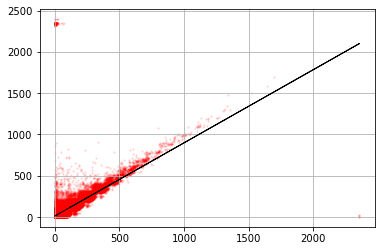

In [43]:
plt.scatter(delay_X, delay_Y, color="red", s=2, alpha=0.1)
plt.plot(delay_X, regr_y_pred, color="black", linewidth=1)

plt.rcParams['figure.figsize'] = [10, 5]

plt.xticks()
plt.yticks()

plt.grid(True)

plt.show()



In [42]:
print("Coefficients: \n", regr.coef_)
print("Mean squared error: %.2f" % mean_squared_error(delay_X, regr_y_pred))
print("Coefficient of determination: %.2f" % r2_score(delay_Y, regr_y_pred))

Coefficients: 
 [[0.88673183]]
Mean squared error: 128.17
Coefficient of determination: 0.48


With an R2 of .48, departure delay has a slight correlation with arrival delay.